# License 
***
Copyright 2017 J. Patrick Hall, phall@h2o.ai & Navdeep Gill, navdeep@h2o.ai

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Monotonic Gradient Boosting using XGBoost 
***
http://xgboost.readthedocs.io/en/latest//tutorials/monotonic.html

Monotonicity is an important facet of intepretability. Monotonicity constraints ensure that the modeled relationship between inputs and the target move in only direction, i.e. as an input increases the target can only increase or as input increases the target can only decrease. Such monotonic relationships are usually easier to explain and understand than non-monotonic relationships. 

## Preliminaries: imports, start h2o, load and clean data 

In [1]:
# imports
import h2o
from h2o.estimators.xgboost import H2OXGBoostEstimator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import xgboost as xgb

In [2]:
# start h2o
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 mins 18 secs
H2O cluster version:,3.14.0.2
H2O cluster version age:,2 months and 11 days
H2O cluster name:,H2O_from_python_phall_we1k80
H2O cluster total nodes:,1
H2O cluster free memory:,3.545 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


#### Load and prepare data for modeling

In [3]:
# load clean data
path = '../data/train.csv'
frame = h2o.import_file(path=path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# assign target and inputs
y = 'SalePrice'
X = [name for name in frame.columns if name not in [y, 'Id']]

#### Monotonic constraints are easier to understand for numeric inputs without missing values

In [5]:
# determine column types
# impute
reals, enums = [], []
for key, val in frame.types.items():
    if key in X:
        if val == 'enum':
            enums.append(key)
        else: 
            reals.append(key)
            
_ = frame[reals].impute(method='median')

In [6]:
# split into training and validation
train, valid = frame.split_frame([0.7], seed=12345)

In [7]:
# for convenience create a tuple for xgboost monotone_constraints parameter
mono_constraints = tuple(int(i) for i in np.ones(shape=(int(1), len(reals))).tolist()[0])

## Train a monotonic predictive model
In this XGBoost GBM all the modeled relationships between the inputs and the target are forced to be monotonically increasing.

#### Log transform for better regression results and easy RMSLE in XGBoost

SalePrice
12.2477
12.109
12.3172


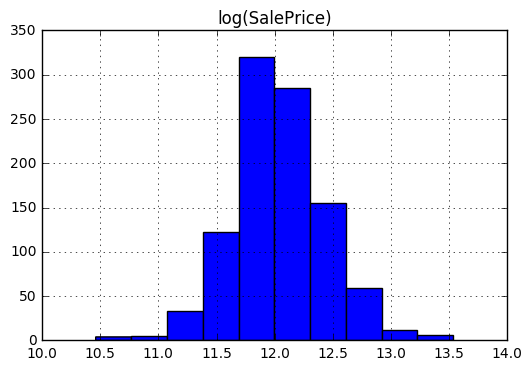

In [8]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Train XGBoost with monotonicity Constraints

In [9]:
ave_y = train['SalePrice'].mean()[0]

# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas data frames 
dtrain = xgb.DMatrix(train.as_data_frame()[reals],
                      train.as_data_frame()['SalePrice'])
dvalid = xgb.DMatrix(valid.as_data_frame()[reals],
                      valid.as_data_frame()['SalePrice'])

# tuning parameters
params = {
    'objective': 'reg:linear',
    'booster': 'gbtree', 
    'eval_metric': 'rmse',
    'eta': 0.005,
    'subsample': 0.1, 
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'reg_alpha' : 0.01,
    'reg_lambda' : 0.0,
    'monotone_constraints':mono_constraints,
    'base_score': ave_y,
    'silent': 0,
    'seed': 12345,
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

# train model
xgb_model1 = xgb.train(params, 
                       dtrain, 
                       1000,
                       evals=watchlist, 
                       early_stopping_rounds=50, 
                       verbose_eval=True)


[0]	train-rmse:0.392431	eval-rmse:0.410079
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:0.391062	eval-rmse:0.408674
[2]	train-rmse:0.389529	eval-rmse:0.4069
[3]	train-rmse:0.38811	eval-rmse:0.405219
[4]	train-rmse:0.386611	eval-rmse:0.40371
[5]	train-rmse:0.385231	eval-rmse:0.402377
[6]	train-rmse:0.383691	eval-rmse:0.400755
[7]	train-rmse:0.382397	eval-rmse:0.399372
[8]	train-rmse:0.381199	eval-rmse:0.398078
[9]	train-rmse:0.379837	eval-rmse:0.396727
[10]	train-rmse:0.378368	eval-rmse:0.395283
[11]	train-rmse:0.376946	eval-rmse:0.393859
[12]	train-rmse:0.375447	eval-rmse:0.392114
[13]	train-rmse:0.374336	eval-rmse:0.390895
[14]	train-rmse:0.372965	eval-rmse:0.389596
[15]	train-rmse:0.371436	eval-rmse:0.387973
[16]	train-rmse:0.370199	eval-rmse:0.386722
[17]	train-rmse:0.369015	eval-rmse:0.385658
[18]	train-rmse:0.367512	eval-rmse:0.384181
[19]	train-rmse:0.366041	eval-rmse:

#### Plot variable importance

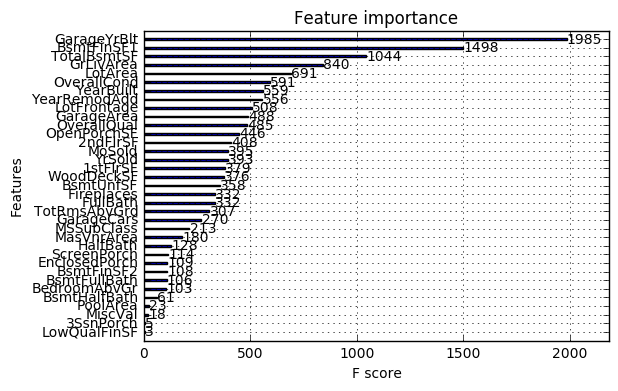

In [10]:
_ = xgb.plot_importance(xgb_model1)

## Examine monotonic behavior with partial dependence and ICE
* Partial dependence is used to view the global, average behavior of a variable under the monotonic model.
* ICE is used to view the local behavior of a single instance and single variable under the monotonic model.
* Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior.

#### Helper function for calculating partial dependence

In [11]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: H2OFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # don't show progress bars for parse
    h2o.no_progress()
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        dframe = xgb.DMatrix(frame.as_data_frame(),)
        par_dep_i = h2o.H2OFrame(model.predict(dframe).tolist())
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame


#### Calculate partial dependence for 3 important variables

In [12]:
par_dep_OverallCond = par_dep('OverallCond', valid[reals], xgb_model1)
par_dep_GrLivArea = par_dep('GrLivArea', valid[reals], xgb_model1)
par_dep_LotArea = par_dep('LotArea', valid[reals], xgb_model1)

#### Helper function for finding decile indices

In [13]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame.as_data_frame()
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict


#### Calculate deciles of SaleProce

In [14]:
quantile_dict = get_quantile_dict('SalePrice', 'Id', valid)

#### Calculate values for ICE

In [15]:
bins_OverallCond = list(par_dep_OverallCond['OverallCond'])
bins_GrLivArea = list(par_dep_GrLivArea['GrLivArea'])
bins_LotArea = list(par_dep_LotArea['LotArea'])

for i in sorted(quantile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    par_dep_OverallCond[col_name] = par_dep('OverallCond', 
                                            valid[valid['Id'] == int(quantile_dict[i])][reals], 
                                            xgb_model1, 
                                            bins=bins_OverallCond)['partial_dependence']
    
    par_dep_GrLivArea[col_name] = par_dep('GrLivArea', 
                                          valid[valid['Id'] == int(quantile_dict[i])][reals], 
                                          xgb_model1, 
                                          bins=bins_GrLivArea)['partial_dependence']
    
    par_dep_LotArea[col_name] = par_dep('LotArea', 
                                         valid[valid['Id'] == int(quantile_dict[i])][reals], 
                                         xgb_model1, 
                                         bins=bins_LotArea)['partial_dependence']

#### Plot Partial Dependence and ICE

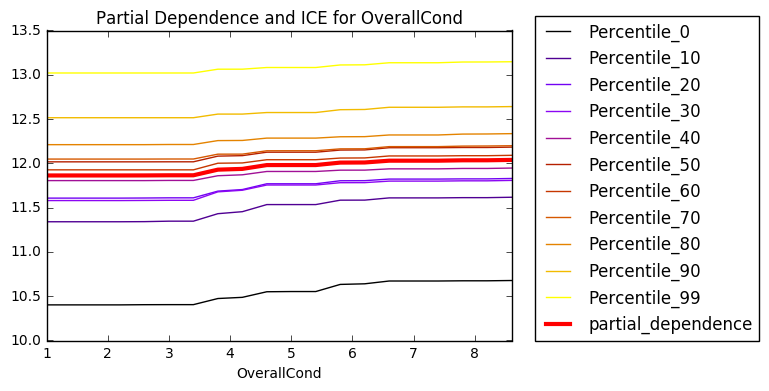

In [16]:
# OverallCond

fig, ax = plt.subplots()
par_dep_OverallCond.drop('partial_dependence', axis=1).plot(x='OverallCond', colormap='gnuplot', ax=ax)

par_dep_OverallCond.plot(title='Partial Dependence and ICE for OverallCond',
                         x='OverallCond', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

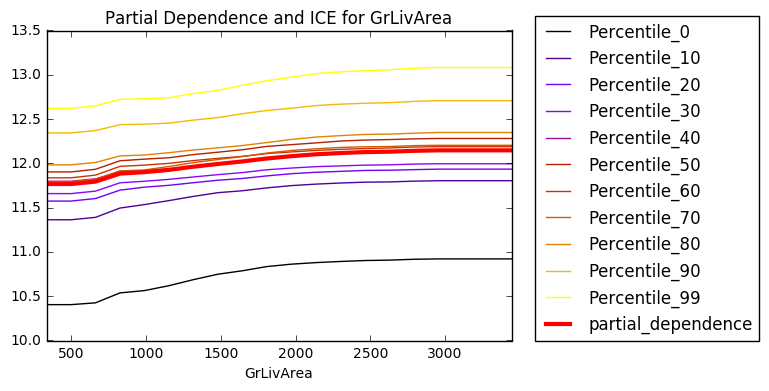

In [17]:
# GrLivArea

fig, ax = plt.subplots()
par_dep_GrLivArea.drop('partial_dependence', axis=1).plot(x='GrLivArea', colormap='gnuplot', ax=ax)

par_dep_GrLivArea.plot(title='Partial Dependence and ICE for GrLivArea',
                         x='GrLivArea', 
                         y='partial_dependence',
                         style='r-', 
                         linewidth=3, 
                         ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

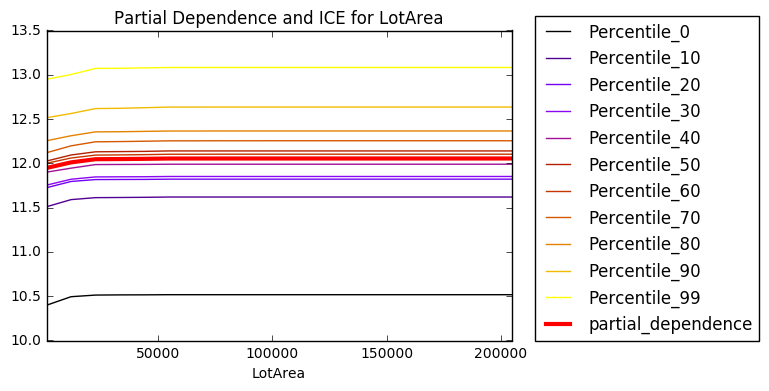

In [18]:
# LotArea

fig, ax = plt.subplots()
par_dep_LotArea.drop('partial_dependence', axis=1).plot(x='LotArea', colormap='gnuplot', ax=ax)

par_dep_LotArea.plot(title='Partial Dependence and ICE for LotArea',
                     x='LotArea', 
                     y='partial_dependence',
                     style='r-', 
                     linewidth=3, 
                     ax=ax)

_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

#### Shutdown H2O

In [19]:
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_b9a9 closed.
